In [1]:
import pandas as pd
import json

%matplotlib inline
%load_ext autoreload
%autoreload

In [2]:
from approved_venders import get_approved_venders, get_arizona_listings
from approved_venders import get_listings_near, batch_listings_near, batch_arizona_listings

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import matplotlib
matplotlib.style.use('ggplot')

### vender information

In [ ]:
venders = pd.DataFrame(json.loads(get_approved_venders())['bundle'])
venders.to_csv('../../data/Approved_Vendors.csv')

In [ ]:
venders.activeListings.describe()

In [ ]:
mesa_df = pd.DataFrame(json.loads(get_listings_near(offset=0))['bundle'])
#venders.to_csv('../../data/Approved_Vendors.csv')

In [ ]:
mesa_list = batch_listings_near()
mesa_df = pd.concat(mesa_list, axis=0)
mesa_df.to_csv('../../data/city_mesa_df.csv')

In [ ]:
phoenix_list = get_arizona_listings("phoenix")
phoenix_df = pd.concat(phoenix_list, axis=0)
phoenix_df.to_csv('../../data/city_phoenix_df.csv')

### Get AZ Listings

In [ ]:
az_list = batch_arizona_listings()
az_df = pd.concat(az_list2, axis=0)
az_df.to_csv('../../data/az_df.csv')

### common utilties

In [413]:
def gen_filters(indexes):
    list_of_indexes = [i for i in indexes.items()]

    filter_criteria = list_of_indexes[0][1]
    for i, (k,v) in enumerate(list_of_indexes):
        try:
            print(k, sum(v))
            filter_criteria = (filter_criteria & list_of_indexes[i+1][1])
        except IndexError:
            pass

    return filter_criteria

In [440]:
from datetime import datetime

### generate data

In [414]:
from IPython.display import HTML

In [493]:
phoenix_df = pd.read_csv('../../data/city_phoenix_df.csv', index_col=0).reset_index(drop=True)

### Investigate

In [595]:
phoenix_df.city.value_counts()

Phoenix       2388
Mesa            81
Tempe            9
Gilbert          6
Scottsdale       3
Chandler         1
Name: city, dtype: int64

In [596]:
pd.crosstab([phoenix_df.media.notnull(), phoenix_df.status], phoenix_df.closePrice.notnull())

closePrice             False  True 
media status                       
False Active              39      0
      Cancelled           70      0
      Closed               0    730
      Expired              7      0
      Pending              8      0
      Temp Off Market      6      0
True  Active            1590      0
      Pending             38      0

In [597]:
phoenix_df.columns

Index(['aboveGradeFinishedArea', 'accessibilityFeatures', 'acres',
       'additionalParcels', 'address', 'agent', 'appliances', 'baths',
       'bedrooms', 'belowGradeFinishedArea', 'cancelationDate',
       'carportSpaces', 'city', 'closePrice', 'constructionMaterials',
       'contingency', 'cooling', 'coordinates', 'country', 'county',
       'dateListed', 'dateSold', 'daysOnMarket', 'disclosures', 'distanceFrom',
       'expirationDate', 'exteriorFeatures', 'financialDataSource',
       'fireplaceFeatures', 'fireplaces', 'flooring', 'foundationDetails',
       'frontageLength', 'garageSpaces', 'gas', 'halfBaths', 'heating', 'id',
       'lastModified', 'laundry', 'listDate', 'livingArea', 'media',
       'mlsAgentID', 'mlsListingID', 'mlsOfficeID', 'occupantType', 'office',
       'openParking', 'originalPrice', 'ownership', 'parcelNumber', 'pool',
       'poolFeatures', 'poolPrivate', 'possession', 'previousPrice', 'price',
       'privateRemarks', 'publicRemarks', 'roadSurface',

In [598]:
lastday = pd.to_datetime(phoenix_df.lastModified).apply(lambda x:x.date())
listday = pd.to_datetime(phoenix_df.listDate).apply(lambda x:x.date())
#pd.to_datetime(phoenix_df.listDate).astype('datetime[ns]')

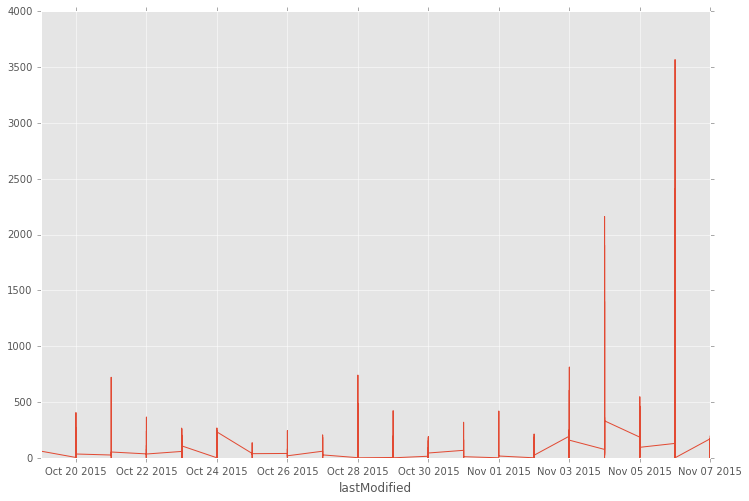

In [601]:
s = pd.Series((lastday - listday).astype('timedelta64[D]').values, lastday)
s = s.sort_index()
s.tail(1000).plot(figsize=(12,8))
#.ix['2015/01/01':].plot(figsize=(12,8))

### Job Pipeline

In [602]:
pre_indexes = {
    "good_bedrooms": (phoenix_df.bedrooms <= 5),
    # "status": phoenix_df.status == 'Pending',
    # "good_datesold": (phoenix_df.dateSold > phoenix_df.listDate),
    # "has_close_price": phoenix_df.closePrice.notnull(),
}

In [603]:
pre_filter_criteria = gen_filters(pre_indexes)

good_bedrooms 2467


In [604]:
pre_df = phoenix_df.drop_duplicates()

In [605]:
cols = [
    'mlsListingID',
    'listDate',
    'dateSold',
    'price',
    'closePrice',
    'bedrooms',
    'baths',
    'squareFootage',
    'constructionMaterials',
    'subtype',
    'media',
    'status',
    'lastModified',
]


In [606]:
calc_df = pre_df.groupby('bedrooms').price.describe().unstack().reset_index()

post_df = pd.merge(pre_df[cols], calc_df, left_on='bedrooms', right_on='bedrooms', suffixes=['','_agg'], how='inner')

In [607]:
## generate new fields
post_df['job_value'] = (post_df['75%'] - post_df.price)/2.


In [608]:
lastday = pd.to_datetime(post_df.lastModified).apply(lambda x:x.date())
post_df['days_since_updated'] = (datetime.now().date() - listday).astype('timedelta64[D]')

In [609]:
post_indexes = {
    # "good_bedrooms": (phoenix_df.bedrooms <= 5),
    "status": post_df.status == 'Pending',
    "job_value": post_df.job_value > 0,
    # "good_datesold": (phoenix_df.dateSold > phoenix_df.listDate),
    # "has_close_price": phoenix_df.closePrice.notnull(),
}

In [610]:
post_filter_criteria = gen_filters(post_indexes)

status 45
job_value 1828


In [611]:
remove_cols = [
    'count',
    'mean',
    'std',
    'min',
    '25%',
    '50%',
    '75%',
    'max'
]

In [612]:
post_df = post_df[post_filter_criteria].sort_values(by='job_value', ascending=False)
final_df = post_df.drop(remove_cols, axis=1)


In [613]:
final_df.T.to_json('../../data/phoenix.json')

### Analysis

phoenix, pending


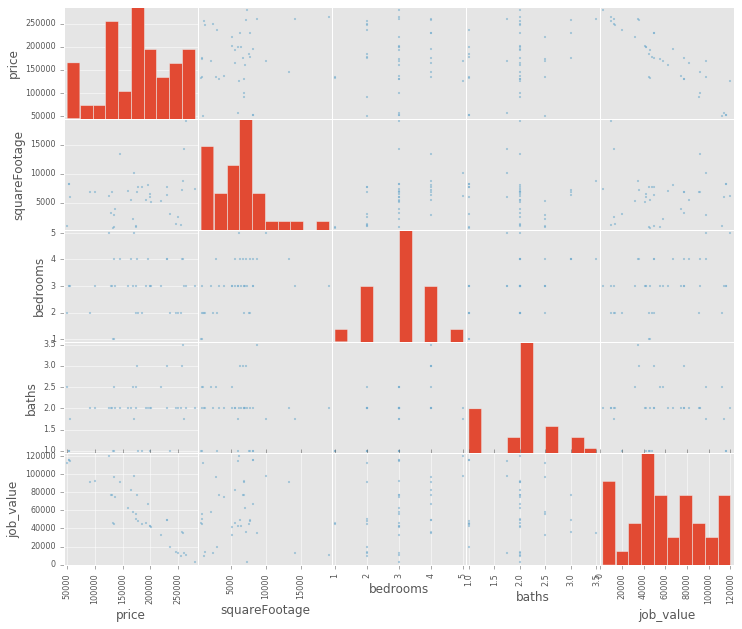

In [439]:
c = ['price', 'squareFootage', 'bedrooms', 'baths', 'job_value']
pd.scatter_matrix(final_df[c], figsize=(12,10))
print("phoenix, pending")

### AZ

In [ ]:
az_df.to_csv('../../data/az_df.csv')

In [ ]:
c = ['baths',
'bedrooms',
'acres',
'squareFootage',
'closePrice',
'daysOnMarket',
'originalPrice',
'price',
'yearBuilt']

In [ ]:
df = az_df[(np.abs(stats.zscore(az_df)) < 3).all(axis=1)]

In [ ]:
df

In [ ]:
pd.scatter_matrix(az_df[c], figsize=(13, 10))
print('AZ 54000+ Listings')

In [ ]:
az_df.to_csv('../../data/az_df.csv')

In [ ]:
mesa_df.city.value_counts()

In [ ]:
m = mesa_df.dropna(axis=1, how='all')

In [ ]:
m.closePrice.dropna().astype(int).describe()

In [ ]:
(mesa_df.closePrice - mesa_df.originalPrice)

In [ ]:
dt = pd.DatetimeIndex(pd.to_datetime(mesa_df.listDate.astype('datetime64[s]'), infer_datetime_format=True).values)


In [ ]:
s = pd.Series(1, index=dt)
s.resample('D', how='sum').fillna(0)

In [ ]:
# s.resample('D', how='sum').plot()

In [ ]:
s.resample('D', how='sum').fillna(0)